
# Notebook Description

This notebook demonstrates a comparative study between two neural network models — a Fixed KAN (Kernel-based Approximation Network) and an Adaptive KAN — for function approximation using Gaussian Radial Basis Function (RBF) layers. The workflow includes:

- **Data Preparation:**  
    Generating a noisy sine function dataset and splitting it into training, validation, and test sets.

- **Model Definition:**  
    Implementing two variants of RBF networks:  
    - *Fixed KAN:* Uses a fixed set of RBF centers and sigmas.  
    - *Adaptive KAN:* Allows the centers and sigmas to be learned during training.

- **Training Process:**  
    Training both models using a common training loop and monitoring the Mean Squared Error (MSE) on the validation set.

- **Evaluation and Visualization:**  
    Evaluating the models on the test set and visualizing:  
    - Loss curves (for both training and validation).  
    - Predictions vs. the true function.  
    - Residuals for further error analysis.

- **Summary Statistics:**  
    Displaying performance metrics (test MSE, minimum validation MSE, Mean Absolute Error, and residual standard deviation) for a comprehensive comparison between the fixed and adaptive approaches.


In [2]:
# Cell: Imports and configuration
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Preparation

In this cell, we will:
- Generate 1000 data points between 0 and 2π.
- Compute their sine values and add Gaussian noise.
- Convert the data to tensors.
- Create a TensorDataset.
- Split the dataset into 70% training, 15% validation, and 15% testing.

In [3]:
# Cell: Generate noisy sine data
X = np.linspace(0, 2*np.pi, 1000)
epsilon = np.random.normal(0, 0.1, X.shape)
y = np.sin(X) + epsilon

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split: 70% train, 15% val, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


### Kolmogorov-Arnold Network (KAN) Architecture

Kolmogorov-Arnold Networks (KANs) are a class of neural networks inspired by the **Kolmogorov-Arnold Representation Theorem**, which states that any continuous multivariate function can be decomposed into a sum of univariate functions composed with addition.

#### Characteristics

- **Basis Functions on Edges:**
  - Instead of scalar weights, each connection between nodes uses a *learnable univariate function* (e.g., spline or radial basis function).
  - This allows each edge to model highly nonlinear transformations.
  
- **No Activations on Nodes:**
  - Nodes simply sum the outputs of incoming basis functions.
  - Nonlinearity comes from the adaptive basis functions themselves.
  
- **Layer Composition:**
  - A KAN layer can be described in matrix form:
$$
    \
    \Phi_{\text{out}} \circ \Phi_{\text{in}}(x)
    \
$$
  where:
  
  - $\Phi_{\text{in}}$ is a matrix of univariate functions applied to each input dimension.
  - $\Phi_{\text{out}}$ sums and composes these outputs.

- **Deep KANs:**
  - Multiple layers are composed to form deeper models, enabling hierarchical function approximation.
$$  
    \
    \text{KAN}(x) = \Phi_1 \circ \Phi_2 \circ \cdots \circ \Phi_L (x)
    \
$$
- **Comparison to MLPs:**
  - In standard MLPs:
    - Linear weights are applied at each layer.
    - Fixed activation functions (e.g., ReLU, tanh) introduce nonlinearity.
  - In KANs:
    - *The weights themselves are learnable functions*, offering richer expressiveness.
    - No explicit activation functions are needed on nodes.

MLPs and KANs follow the same composition structure with layer outputs being passed and inputs into other layers. Given that $W_{L}$ represents layer $L$ and the non linear activation function σ is used through the model.

$$  
    \
    \text{MLP}(x) = (W_{1} \circ σ \circ W_{2} \circ \cdots \circ W_{L}) (x)
    \
$$


#### Benefits of KAN Networks

 - Strong universal approximation capability with fewer nodes per layer

 - Better interpretability of individual basis functions.  

 - Flexible adaptation to complex, nonlinear relationships.

#### Challenges

- More computationally intensive due to function evaluation on each edge.
- Requires careful regularization to avoid overfitting.
- Optimization is more sensitive to initialization and learning dynamics.

KANs are particularly powerful in scenarios where modeling **high-dimensional, highly nonlinear functions** is required.


### Fixed Gaussian RBF Layer

This cell defines the **Fixed Gaussian Radial Basis Function (RBF) Layer** and the **KAN_Fixed model**:

- **`FixedRBF` class:**
  - Implements a set of Gaussian basis functions with *fixed centers and widths*.
  - `num_centers`: number of Gaussian functions.
  - Each Gaussian is defined as:

$$
    \
    \phi_i(x) = \exp\left(-\frac{(x - \mu_i)^2}{2 \sigma_i^2}\right)
    \
$$
  
  - Centers (`μ_i`) are evenly spaced between 0 and 10.
  - Sigmas (`σ_i`) are initialized to 1 and are **not trainable** (`requires_grad=False`).

- **`KAN_Fixed` class:**
  - Composes:
    - The `FixedRBF` layer (computes Gaussian basis function outputs).
    - A `Linear` layer mapping the RBF outputs to a scalar prediction.
  - This model represents a **KAN using static basis functions**, i.e., the Gaussian parameters remain unchanged during training.


In [4]:
# Cell: Fixed Gaussian RBF Layer
class FixedRBF(nn.Module):
    def __init__(self, num_centers):
        super(FixedRBF, self).__init__()
        self.num_centers = num_centers
        centers = torch.linspace(0, 10, num_centers).unsqueeze(1)
        self.centers = nn.Parameter(centers, requires_grad=False)
        self.sigmas = nn.Parameter(torch.ones(num_centers, 1), requires_grad=False)

    def forward(self, x):
        # Gaussian RBF
        diff = x - self.centers.T
        rbf = torch.exp(- (diff ** 2) / (2 * self.sigmas.T ** 2))
        return rbf

class KAN_Fixed(nn.Module):
    def __init__(self, num_centers):
        super(KAN_Fixed, self).__init__()
        self.rbf = FixedRBF(num_centers)
        self.linear = nn.Linear(num_centers, 1)

    def forward(self, x):
        phi = self.rbf(x)
        return self.linear(phi)


### Adaptive Gaussian RBF Layer

This cell defines the **Adaptive Gaussian Radial Basis Function (RBF) Layer** and the **KAN_Adaptive model**:

- **`AdaptiveRBF` class:**
  - Implements a set of Gaussian basis functions where **both centers and sigmas are trainable**.
  - `num_centers`: number of Gaussian functions.
  - Each Gaussian is defined as:
$$
    \
    \phi_i(x) = \exp\left(-\frac{(x - \mu_i)^2}{2 \sigma_i^2}\right)
    \
$$
  - Unlike the fixed version:
    - `centers` (`μ_i`) are initialized evenly between 0 and 10 but are **learned during training** (`requires_grad=True`).
    - `sigmas` (`σ_i`) are also **learned**, enabling the network to adapt the shape and location of each basis function dynamically.

- **`KAN_Adaptive` class:**
  - Composes:
    - The `AdaptiveRBF` layer (outputs adaptive Gaussian basis activations).
    - A `Linear` layer mapping these activations to a scalar prediction.
  - This model represents a **KAN using adaptive basis functions**, allowing it to better capture complex, nonlinear patterns in data.


In [5]:
# Cell: Adaptive Gaussian RBF Layer
class AdaptiveRBF(nn.Module):
    def __init__(self, num_centers):
        super(AdaptiveRBF, self).__init__()
        self.num_centers = num_centers
        self.centers = nn.Parameter(torch.linspace(0, 10, num_centers).unsqueeze(1))
        self.sigmas = nn.Parameter(torch.ones(num_centers, 1))

    def forward(self, x):
        diff = x - self.centers.T
        rbf = torch.exp(- (diff ** 2) / (2 * self.sigmas.T ** 2))
        return rbf

class KAN_Adaptive(nn.Module):
    def __init__(self, num_centers):
        super(KAN_Adaptive, self).__init__()
        self.rbf = AdaptiveRBF(num_centers)
        self.linear = nn.Linear(num_centers, 1)

    def forward(self, x):
        phi = self.rbf(x)
        return self.linear(phi)


In [6]:
# Cell: Training loop
def train_model(model, train_loader, val_loader, epochs=100, lr=0.01):
    train_losses = []
    val_losses = []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * xb.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                epoch_val_loss += loss.item() * xb.size(0)

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

    return train_losses, val_losses


In [7]:
# Cell: Train fixed KAN
fixed_model = KAN_Fixed(num_centers=20).to(device)
fixed_train_loss, fixed_val_loss = train_model(fixed_model, train_loader, val_loader)

# Cell: Train adaptive KAN
adaptive_model = KAN_Adaptive(num_centers=20).to(device)
adaptive_train_loss, adaptive_val_loss = train_model(adaptive_model, train_loader, val_loader)


Epoch 0: Train Loss=0.2122, Val Loss=0.0691
Epoch 10: Train Loss=0.0119, Val Loss=0.0109
Epoch 20: Train Loss=0.0106, Val Loss=0.0101
Epoch 30: Train Loss=0.0107, Val Loss=0.0087
Epoch 40: Train Loss=0.0102, Val Loss=0.0087
Epoch 50: Train Loss=0.0100, Val Loss=0.0086
Epoch 60: Train Loss=0.0100, Val Loss=0.0085
Epoch 70: Train Loss=0.0102, Val Loss=0.0085
Epoch 80: Train Loss=0.0102, Val Loss=0.0087
Epoch 90: Train Loss=0.0106, Val Loss=0.0084
Epoch 0: Train Loss=0.1818, Val Loss=0.0509
Epoch 10: Train Loss=0.0100, Val Loss=0.0083
Epoch 20: Train Loss=0.0099, Val Loss=0.0082
Epoch 30: Train Loss=0.0100, Val Loss=0.0090
Epoch 40: Train Loss=0.0100, Val Loss=0.0083
Epoch 50: Train Loss=0.0102, Val Loss=0.0083
Epoch 60: Train Loss=0.0099, Val Loss=0.0084
Epoch 70: Train Loss=0.0099, Val Loss=0.0090
Epoch 80: Train Loss=0.0099, Val Loss=0.0082
Epoch 90: Train Loss=0.0097, Val Loss=0.0088


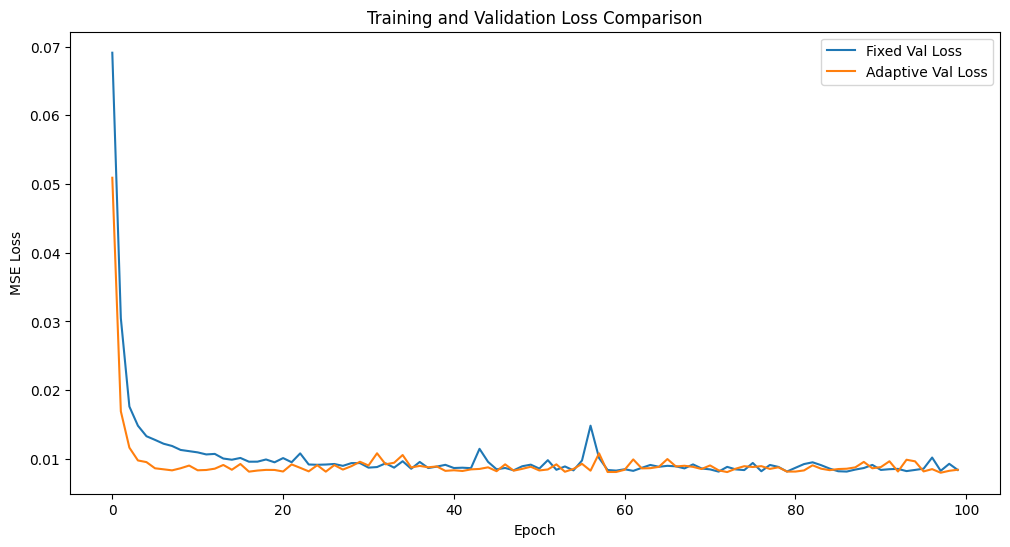

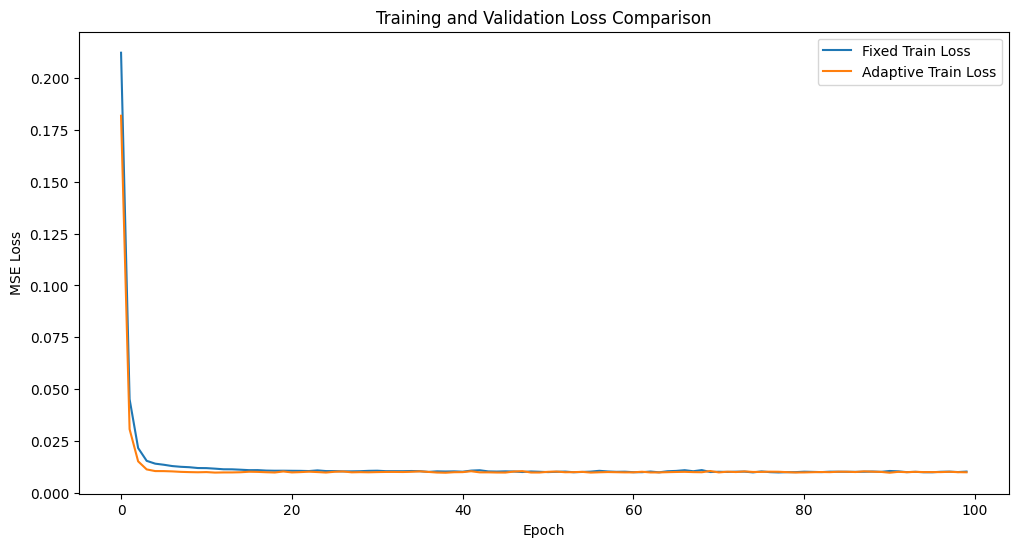

Fixed KAN Test MSE: 0.0114
Adaptive KAN Test MSE: 0.0105


<Figure size 640x480 with 0 Axes>

In [8]:
# Cell: Plot loss curves
plt.figure(figsize=(12,6))
plt.plot(fixed_val_loss, label="Fixed Val Loss")
plt.plot(adaptive_val_loss, label="Adaptive Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss Comparison")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(fixed_train_loss, label="Fixed Train Loss")
plt.plot(adaptive_train_loss, label="Adaptive Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss Comparison")
plt.show()

plt.tight_layout()

# Cell: Test set evaluation
def test_mse(model, loader):
    criterion = nn.MSELoss()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            total_loss += criterion(preds, yb).item() * xb.size(0)
    return total_loss / len(loader.dataset)

fixed_test_loss = test_mse(fixed_model, test_loader)
adaptive_test_loss = test_mse(adaptive_model, test_loader)

print(f"Fixed KAN Test MSE: {fixed_test_loss:.4f}")
print(f"Adaptive KAN Test MSE: {adaptive_test_loss:.4f}")


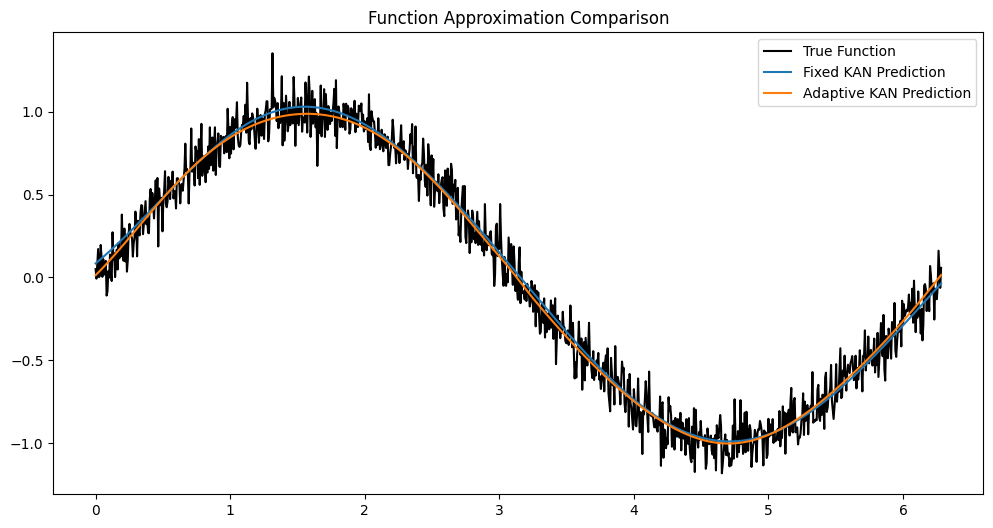

In [9]:
# Cell: Visualize predictions
X_test_sorted, y_test_sorted = zip(*sorted(zip(X_tensor.squeeze().numpy(), y_tensor.squeeze().numpy())))

fixed_preds = fixed_model(torch.tensor(X_test_sorted, dtype=torch.float32).unsqueeze(1).to(device)).cpu().detach().numpy()
adaptive_preds = adaptive_model(torch.tensor(X_test_sorted, dtype=torch.float32).unsqueeze(1).to(device)).cpu().detach().numpy()

plt.figure(figsize=(12,6))
plt.plot(X_test_sorted, y_test_sorted, label="True Function", color="black")
plt.plot(X_test_sorted, fixed_preds, label="Fixed KAN Prediction")
plt.plot(X_test_sorted, adaptive_preds, label="Adaptive KAN Prediction")
plt.legend()
plt.title("Function Approximation Comparison")
plt.show()


In [10]:
# Cell: Summary
import pandas as pd

results = pd.DataFrame({
    "Model": ["Fixed KAN", "Adaptive KAN"],
    "Test MSE": [fixed_test_loss, adaptive_test_loss],
    "Min Val MSE": [min(fixed_val_loss), min(adaptive_val_loss)]
})
display(results)


,Model,Test MSE,Min Val MSE
0,Fixed KAN,0.011407,0.008145
1,Adaptive KAN,0.010541,0.007987


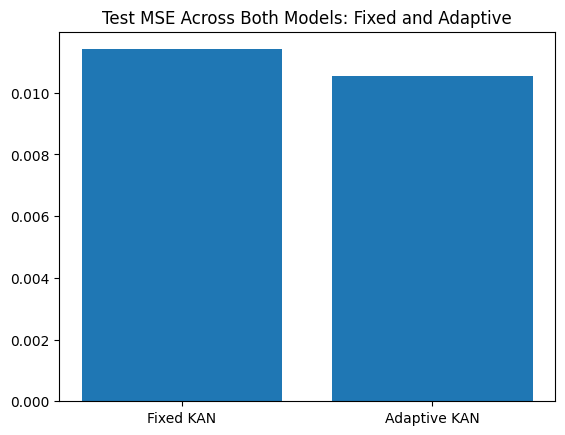

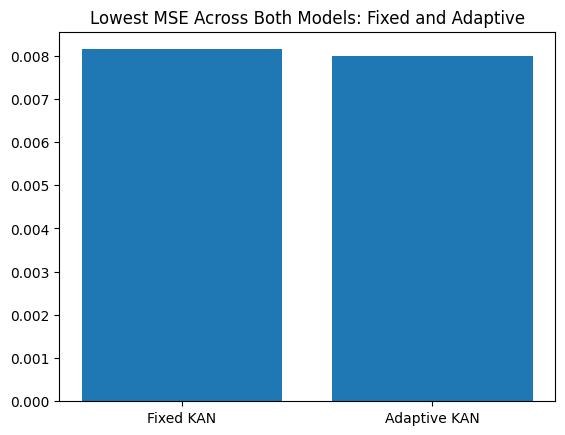

<Figure size 640x480 with 0 Axes>

In [11]:
plt.bar(results['Model'], results['Test MSE'])
plt.title("Test MSE Across Both Models: Fixed and Adaptive")
plt.show()

plt.bar(results['Model'], results['Min Val MSE'])
plt.title("Lowest MSE Across Both Models: Fixed and Adaptive")
plt.show()

plt.tight_layout()

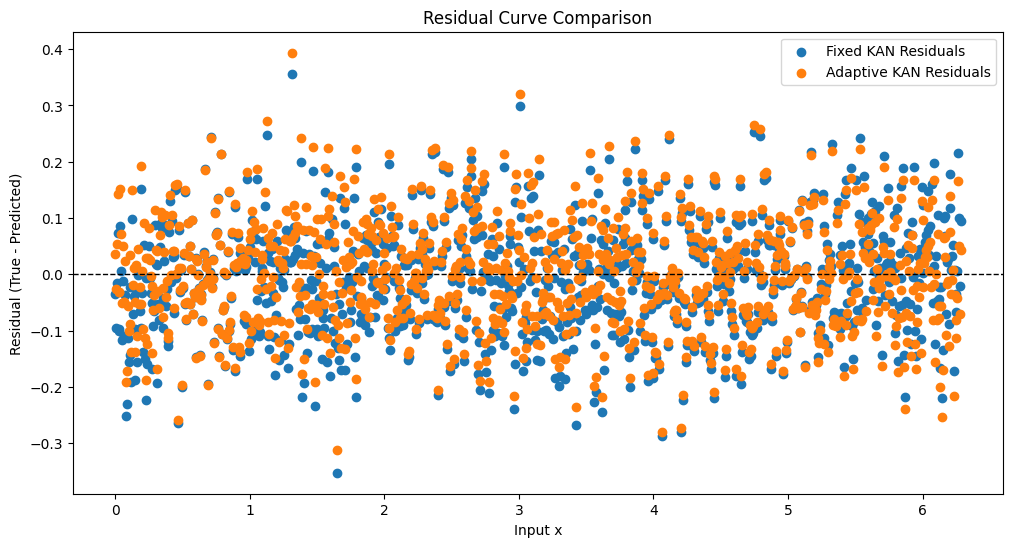

In [33]:
# Compute residuals on test set
fixed_residuals = y_test_sorted - fixed_preds.squeeze()
adaptive_residuals = y_test_sorted - adaptive_preds.squeeze()

# Plot residual curves
plt.figure(figsize=(12, 6))
plt.scatter(X_test_sorted, fixed_residuals, label="Fixed KAN Residuals")
plt.scatter(X_test_sorted, adaptive_residuals, label="Adaptive KAN Residuals")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Input x")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Curve Comparison")
plt.legend()
plt.show()


In [13]:
fixed_mae = sum(abs(fixed_residuals))/len(fixed_residuals)
adaptive_mae = sum(abs(adaptive_residuals))/len(adaptive_residuals)

In [14]:
adaptive_mae

np.float32(0.077899605)

In [15]:
fixed_mae

np.float32(0.07931654)

In [16]:
fixed_residual_std = np.std(fixed_residuals)
adaptive_residual_std = np.std(adaptive_residuals)
print(f"Fixed KAN residual std: {fixed_residual_std:.4f}")
print(f"Adaptive KAN residual std: {adaptive_residual_std:.4f}")

Fixed KAN residual std: 0.0990
Adaptive KAN residual std: 0.0976
